# Metrics

This guide gives you a brief introduction to Rubrix Metrics. Rubrix Metrics enable you to perform fine-grained analyses of your models and training datasets. Rubrix Metrics are inspired by a a number of seminal works such as [Explainaboard](http://explainaboard.nlpedia.ai/). 

The main goal is to make it easier to build more robust models and training data, going beyond single-number metrics (e.g., F1). 

This guide gives a brief overview of currently supported metrics. For the full API documentation see the [Python API reference](../reference/python/python_metrics.rst)


.. nbinfo::
This feature is experimental, you can expect some changes in the Python API. Please report on Github any issue you encounter.


## Install dependencies

.. nbinfo::
Verify you have already installed Jupyter Widgets in order to properly visualize the plots.
See https://ipywidgets.readthedocs.io/en/latest/user_install.html

For running this guide you need to install the following dependencies:

In [ ]:
%pip install datasets spacy plotly -qqq

and the spacy model:

In [ ]:
!python -m spacy download en_core_web_sm

## 1. Rubrix Metrics for NER pipelines predictions

### Load dataset and spaCy model

We'll be using spaCy for this guide, but all the metrics we'll see are computed for any other framework (Flair, Stanza, Hugging Face, etc.). As an example will use the WNUT17 NER dataset.

In [ ]:
import rubrix as rb
import spacy
from datasets import load_dataset

nlp = spacy.load("en_core_web_sm")
dataset = load_dataset("wnut_17", split="train")

### Log records into a Rubrix dataset

Let's log spaCy predictions using the built-in `rb.monitor` method:

In [ ]:
nlp = rb.monitor(nlp, dataset="spacy_sm_wnut17")

def predict_batch(records):
    docs = nlp(" ".join(records["tokens"]))
    return {"predicted": [True for _ in docs]}

dataset.map(predict_batch)

### Explore the metrics for this pipeline

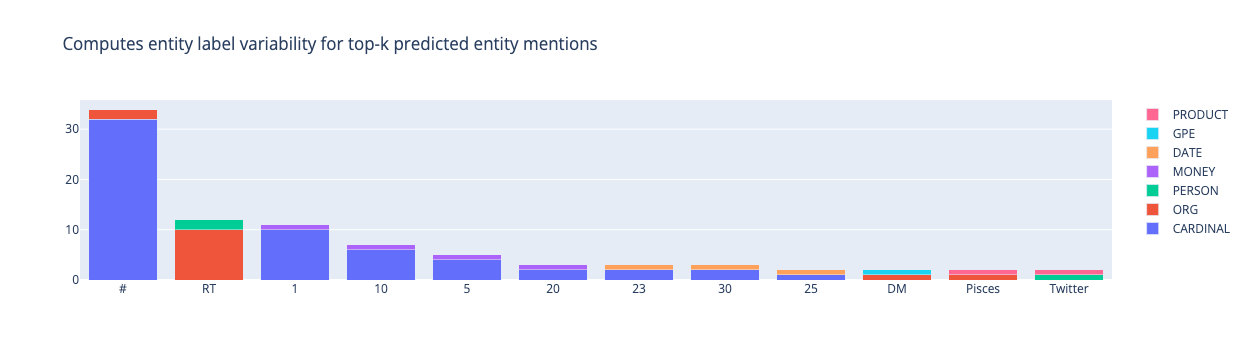

In [35]:
from rubrix.metrics.token_classification import entity_consistency

entity_consistency(name="spacy_sm_wnut17", mentions=5000, threshold=2).visualize()

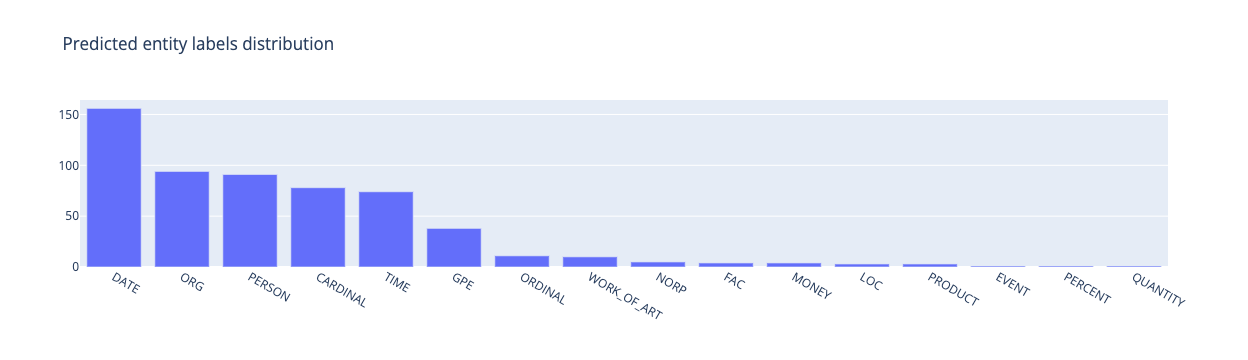

In [15]:
from rubrix.metrics.token_classification import entity_labels

entity_labels(name="spacy_sm_wnut17").visualize()

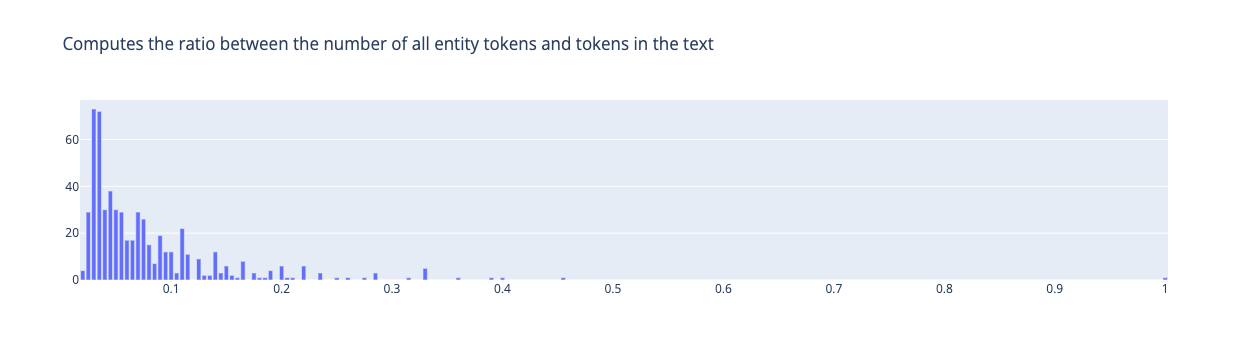

In [16]:
from rubrix.metrics.token_classification import entity_density

entity_density(name="spacy_sm_wnut17").visualize()

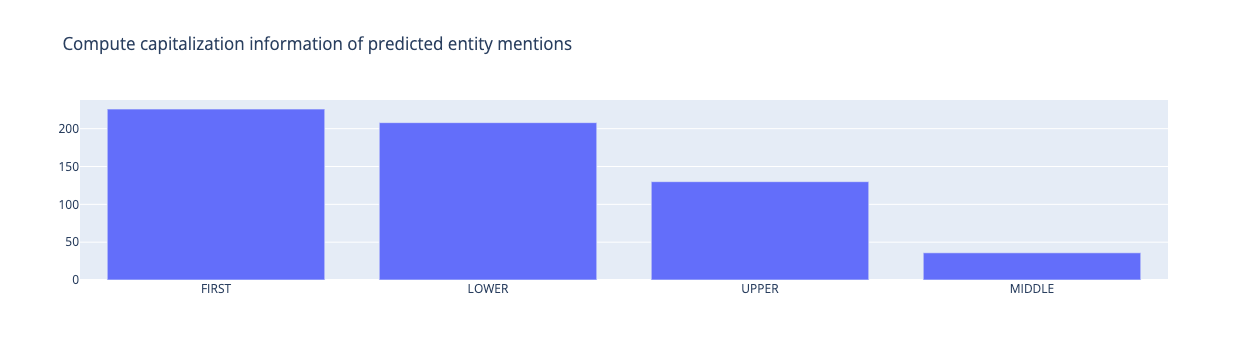

In [17]:
from rubrix.metrics.token_classification import entity_capitalness

entity_capitalness(name="spacy_sm_wnut17").visualize()

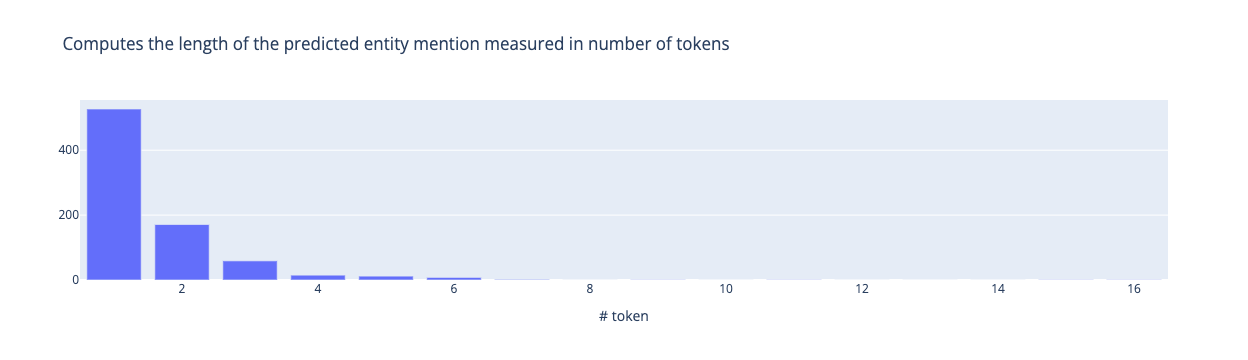

In [19]:
from rubrix.metrics.token_classification import mention_length
mention_length(name="spacy_sm_wnut17").visualize()

## 2. Rubrix Metrics for training sets

### Analyzing tags

In [20]:
dataset = load_dataset("conll2002", "es", split="train[0:5000]")

Downloading:   0%|          | 0.00/2.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

Reusing dataset conll2002 (/Users/dani/.cache/huggingface/datasets/conll2002/es/1.0.0/a3a8a8612caf57271f5b35c5ae1dd25f99ddb9efb9c1667abaa70ede33e863e5)


In [24]:
def parse_entities(record):
    entities = []
    counter = 0
    for i in range(len(record['ner_tags'])):
        entity = (dataset.features["ner_tags"].feature.names[record["ner_tags"][i]], counter, counter + len(record["tokens"][i]))
        entities.append(entity)
        counter += len(record["tokens"][i]) + 1
    return entities

In [30]:
records = [
    rb.TokenClassificationRecord(
        text=" ".join(example["tokens"]),
        tokens=example["tokens"],
        annotation=parse_entities(example)
    )
    for example in dataset
] 

In [ ]:
rb.log(records, "conll2002_es")

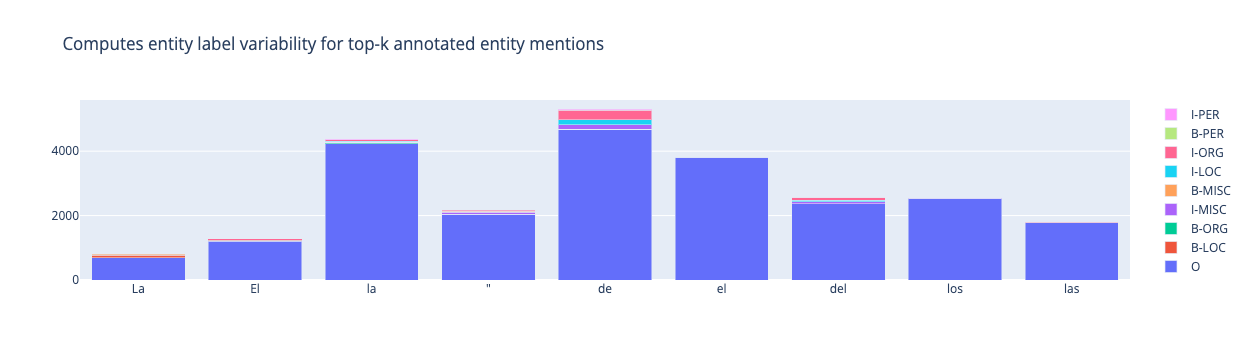

In [51]:
from rubrix.metrics.token_classification import entity_consistency
from rubrix.metrics.token_classification.metrics import Annotations

entity_consistency(name="conll2002_es", mentions=30, threshold=4, compute_for=Annotations).visualize()

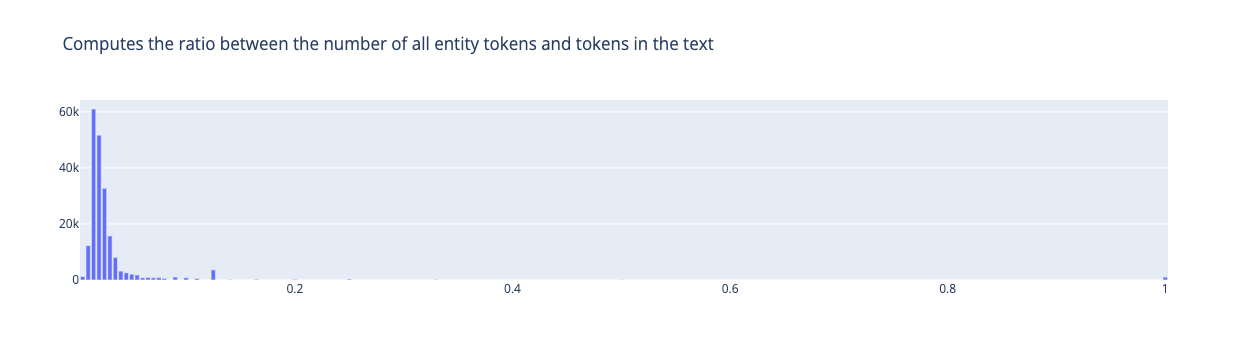

In [54]:
from rubrix.metrics.token_classification import *

entity_density(name="conll2002_es", compute_for=Annotations).visualize()